# Building an Image Pipeline

Resources:
- https://pgaleone.eu/tensorflow/2018/07/28/understanding-tensorflow-tensors-shape-static-dynamic/
- https://www.tensorflow.org/guide/data
- https://cs230-stanford.github.io/tensorflow-input-data.html#building-an-image-data-pipeline
- https://medium.com/ymedialabs-innovation/how-to-use-dataset-and-iterators-in-tensorflow-with-code-samples-3bb98b6b74ab

In [2]:
import sys
import os
import numpy as np
import tensorflow as tf

import pathlib
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.insert(0,'..')
from dataset_collection.dataset.image import tiny_imagenet

In [9]:
def read_image(filename):
    
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    return image

def rescale_image(image, size=(227,227)):
    return tf.image.resize(image, size)

def ensure_rgb(image):
    image_rgb = tf.cond(tf.equal(tf.shape(image)[-1], 3),
                        lambda: image,
                        lambda: tf.image.grayscale_to_rgb(image))

    image_rgb.set_shape((None, None, 3))

    return image_rgb

def make_image_pipeline(dataset,
                        shuffle=True,
                        reshape_to=(227,227),
                        shuffle_len=100,
                        num_parallel_calls=4,
                        epochs=1,
                        batch_size=1024,
                        prefetch=1):
    if shuffle:
        dataset = dataset.shuffle(shuffle_len)
    dataset = dataset.map(lambda feature, label: [read_image(feature), label], num_parallel_calls=num_parallel_calls)
    dataset = dataset.map(lambda feature, label: [rescale_image(feature, size=reshape_to), label], num_parallel_calls=num_parallel_calls)
    dataset = dataset.map(lambda feature, label: [ensure_rgb(feature), label], num_parallel_calls=num_parallel_calls)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(prefetch)
    
    return dataset

def show(image, label):
    plt.figure()
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')

In [26]:
DATASET_ROOT = '../../data'

dset = tiny_imagenet(DATASET_ROOT)
df = dset.get_description_map()
label_to_index = { k: idx for idx, (k,v) in enumerate(df.items()) }
index_to_label = { v: k for k,v in label_to_index.items() }

train_uris, train_labels = dset.get_train_dataset()
train_labels = [label_to_index[ll] for ll in train_labels]

val_uris, val_labels = dset.get_val_dataset()
val_labels = [label_to_index[ll] for ll in val_labels]

In [27]:
tf.reset_default_graph()

In [28]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_uris, train_labels))
train_dataset = make_image_pipeline(train_dataset,
                                    shuffle=True,
                                    reshape_to=(227,227),
                                    shuffle_len=len(train_uris),
                                    num_parallel_calls=4,
                                    epochs=1,
                                    batch_size=1024,
                                    prefetch=1)

train_iterator = tf.compat.v1.data.make_one_shot_iterator(train_dataset)
train_next_element = train_iterator.get_next()


val_dataset = tf.data.Dataset.from_tensor_slices((val_uris, val_labels))
val_dataset = make_image_pipeline(val_dataset,
                                  shuffle=True,
                                  reshape_to=(227,227),
                                  shuffle_len=len(train_uris),
                                  num_parallel_calls=4,
                                  epochs=1,
                                  batch_size=1024,
                                  prefetch=1)

val_iterator = tf.compat.v1.data.make_one_shot_iterator(val_dataset)
val_next_element = val_iterator.get_next()

In [19]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('TRAIN')
    try:
        train_idx = 0
        while True:
            image, label = sess.run(train_next_element)
            print('{} --> features: {} labels: {}'.format(train_idx, image.shape, label.shape))
            train_idx += 1
    except tf.errors.OutOfRangeError:
        pass
    
    print('VAL')
    try:
        val_idx = 0
        while True:
            image, label = sess.run(val_next_element)
            print('{} --> features: {} labels: {}'.format(val_idx, image.shape, label.shape))
            val_idx += 1
    except tf.errors.OutOfRangeError:
        pass

TRAIN
0 --> features: (1024, 227, 227, 3) labels: (1024,)
1 --> features: (1024, 227, 227, 3) labels: (1024,)
2 --> features: (1024, 227, 227, 3) labels: (1024,)
3 --> features: (1024, 227, 227, 3) labels: (1024,)
4 --> features: (1024, 227, 227, 3) labels: (1024,)
5 --> features: (1024, 227, 227, 3) labels: (1024,)
6 --> features: (1024, 227, 227, 3) labels: (1024,)
7 --> features: (1024, 227, 227, 3) labels: (1024,)
8 --> features: (1024, 227, 227, 3) labels: (1024,)
9 --> features: (1024, 227, 227, 3) labels: (1024,)
10 --> features: (1024, 227, 227, 3) labels: (1024,)
11 --> features: (1024, 227, 227, 3) labels: (1024,)
12 --> features: (1024, 227, 227, 3) labels: (1024,)
13 --> features: (1024, 227, 227, 3) labels: (1024,)
14 --> features: (1024, 227, 227, 3) labels: (1024,)
15 --> features: (1024, 227, 227, 3) labels: (1024,)
16 --> features: (1024, 227, 227, 3) labels: (1024,)
17 --> features: (1024, 227, 227, 3) labels: (1024,)
18 --> features: (1024, 227, 227, 3) labels: (1024

VAL


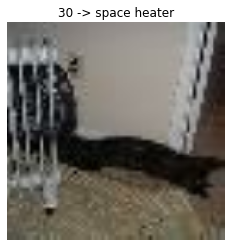

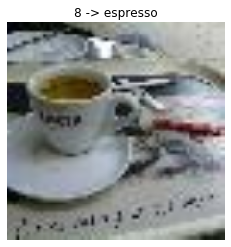

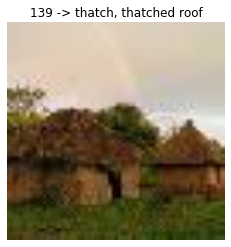

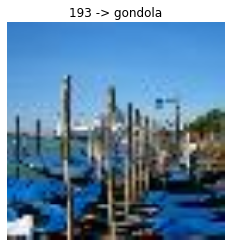

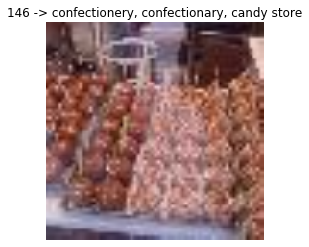

In [34]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
        
    print('VAL')
    image, label = sess.run(val_next_element)
    for img, ll in zip(image[:5], label[:5]):
        show(img,' '.join([str(ll), '->', df[index_to_label[ll]]]))

TRAIN


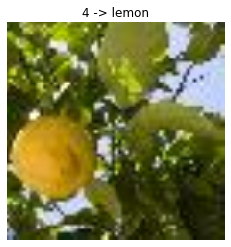

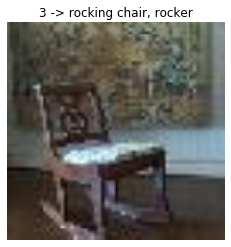

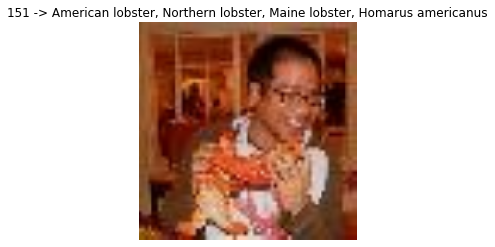

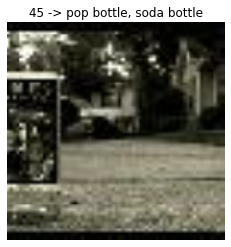

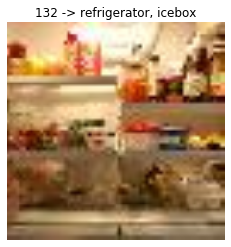

In [33]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print('TRAIN')
    image, label = sess.run(train_next_element)
    for img, ll in zip(image[:5], label[:5]):
        show(img,' '.join([str(ll), '->', df[index_to_label[ll]]]))